In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy

import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import warnings
warnings.simplefilter("ignore", UserWarning)

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.set_figure_params(dpi=80)

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in original adata

In [5]:
# atlas
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor.h5ad')
adata

AnnData object with n_obs × n_vars = 83477 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'euploid_or_t21', 'donor_type', 'region_finest', 'flushed', 'scrublet_leiden', 'cluster_scrublet_score', 'leiden_scVI_0.1', 'leiden

In [6]:
adata.obs['region'].value_counts()

Heart                              32788
whole sample                       24433
Pericardial sac + RA + LA + IAS     5084
node                                4298
Left ventricle                      3888
Right ventricle                     3792
heart without node                  3624
Left atria                          3475
Great vessels                       2095
Name: region, dtype: int64

# Add scVI latent space

In [7]:
latent_file_name_list = os.listdir('/nfs/team205/heart/anndata_objects/Foetal/scVI/latent_variables')
latent_file_name_list = [x.split('.h5ad')[0] for x in latent_file_name_list if 'correcting-donor-region_n-layers-2' in x]
latent_file_name_list

['Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor_correcting-donor-region_n-layers-2']

In [9]:
for latent_file_name in latent_file_name_list:
    latent_space_condition = latent_file_name.split('subsampled-per-cellstate-donor_')[1]
    latent = sc.read_h5ad(f'/nfs/team205/heart/anndata_objects/Foetal/scVI/latent_variables/{latent_file_name}.h5ad')
    # add latent space
    adata.obsm[f'scVI_latent_{latent_space_condition}']=latent.X.copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 83477 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'euploid_or_t21', 'donor_type', 'region_finest', 'flushed', 'scrublet_leiden', 'cluster_scrublet_score', 'leiden_scVI_0.1', 'leiden

# Find neighbors, UMAP/Clustering

##### correcting-donor-region_n-layers-2 #####


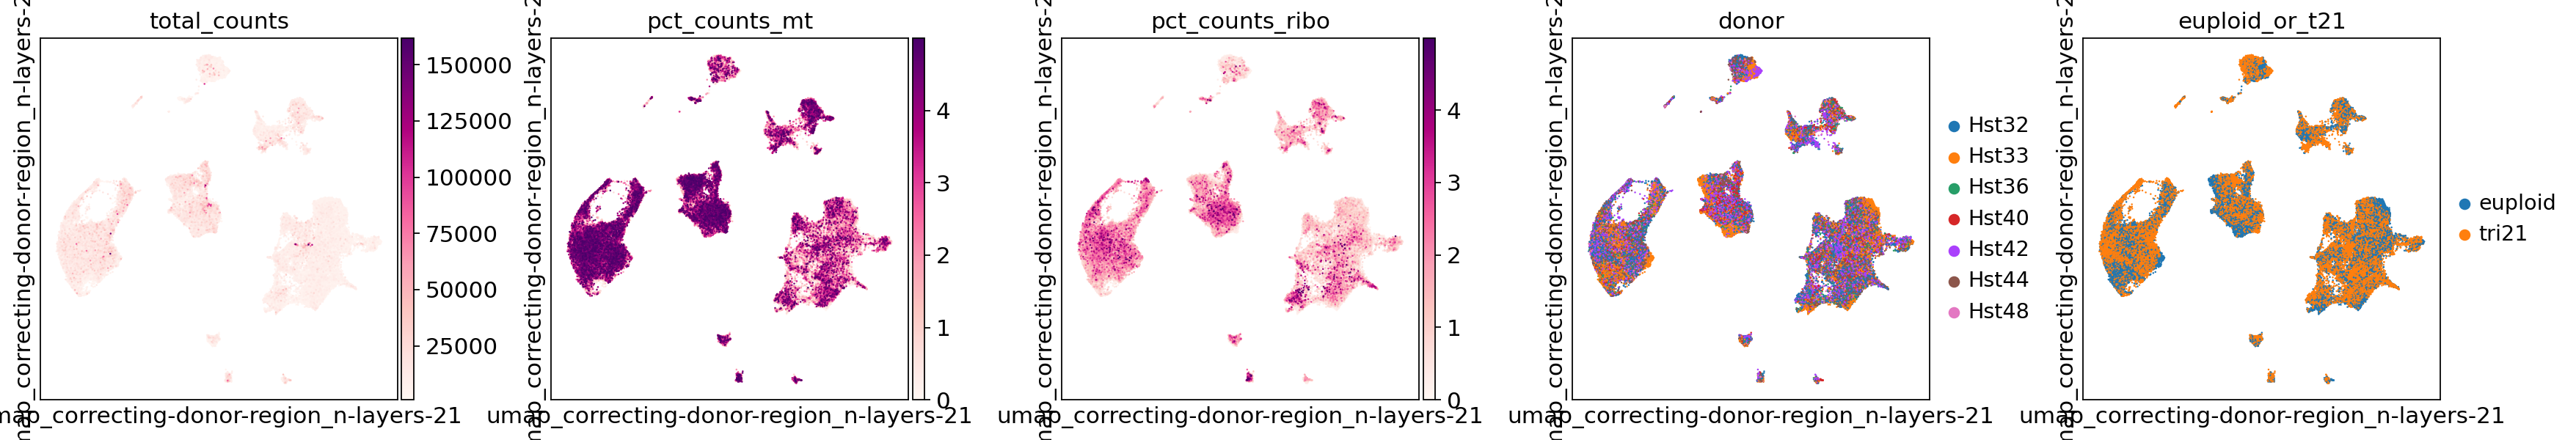

In [11]:
for latent_file_name in latent_file_name_list:
    latent_space_condition = latent_file_name.split('subsampled-per-cellstate-donor_')[1]
    print(f'##### {latent_space_condition} #####')
    sc.pp.neighbors(adata, use_rep=f'scVI_latent_{latent_space_condition}',n_neighbors=15,key_added=latent_space_condition)
    sc.tl.umap(adata, min_dist=0.2, spread=1.0, neighbors_key=latent_space_condition)# 
    adata.obsm[f'X_umap_{latent_space_condition}'] = adata.obsm[f'X_umap'].copy()
    del adata.obsm[f'X_umap']
    # check batches
    sc.pl.embedding(adata, basis=f'umap_{latent_space_condition}',
                    color=['total_counts','pct_counts_mt','pct_counts_ribo','donor','euploid_or_t21'], 
               size=5, wspace=0.3, ncols=6, components='all',cmap='RdPu')
    print('')
    print('')

In [12]:
f'umap_{latent_space_condition}'

'umap_correcting-donor-region_n-layers-2'

# Inspecting each cell types

In [13]:
basis = 'umap_correcting-donor-region_n-layers-2'

In [14]:
set(adata.obs['coarse_grain_merged'])

{'Cardiomyocytes',
 'Endothelium',
 'Epicardium',
 'Leukocytes',
 'Mesenchymal',
 'Neural'}

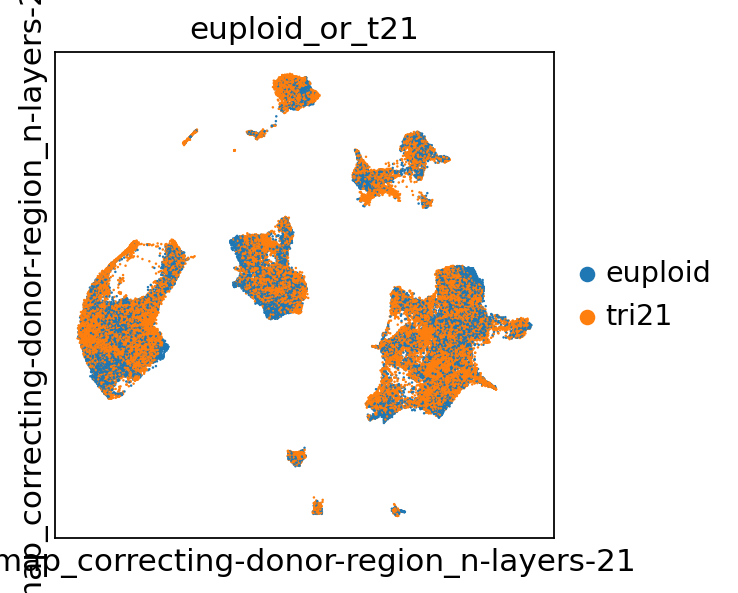

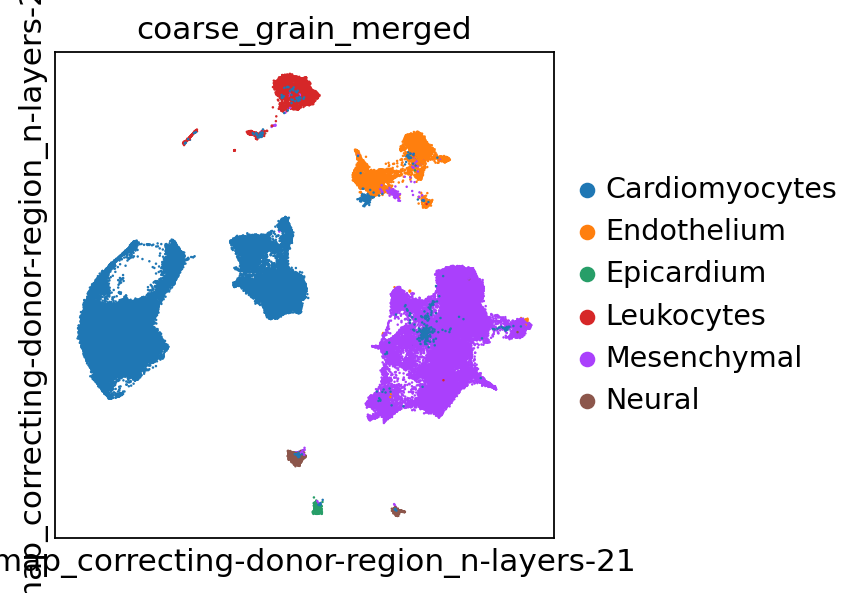

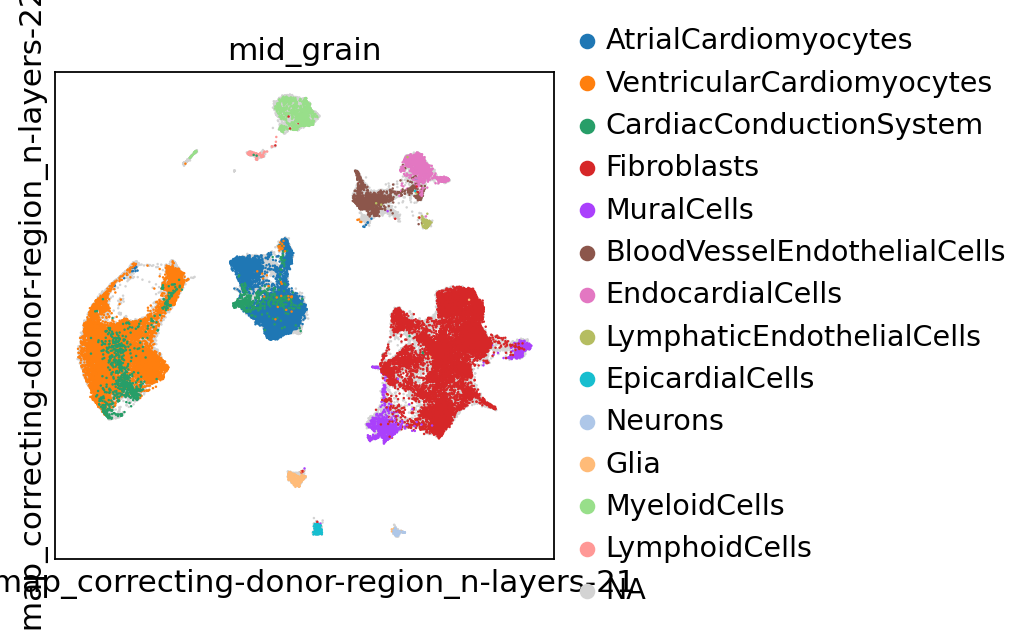

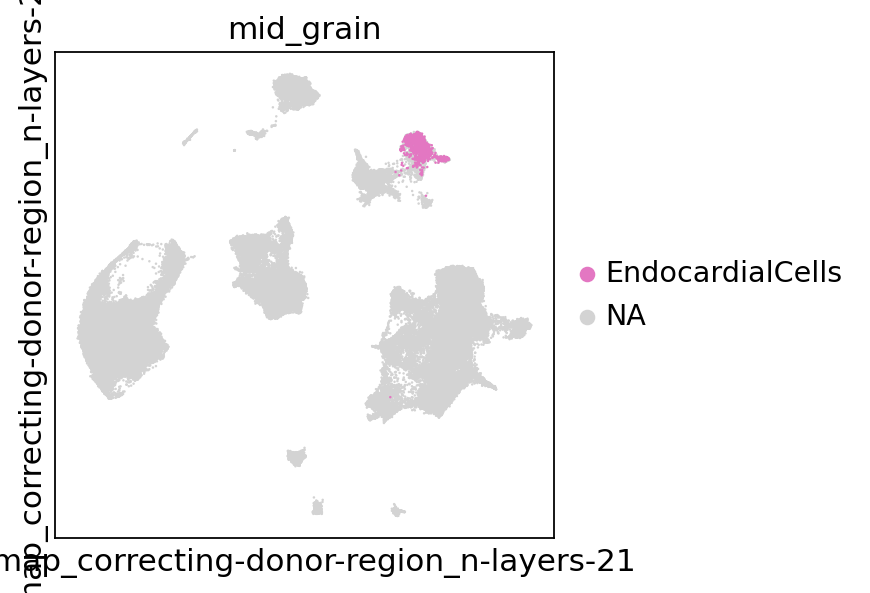

In [15]:
sc.pl.embedding(adata, basis=basis, color=['euploid_or_t21'], 
               size=5, wspace=0.3, ncols=6, components='all',cmap='RdPu')
sc.pl.embedding(adata, basis=basis, color=['coarse_grain_merged'], 
               size=5, wspace=0.3, ncols=6, components='all',cmap='RdPu')
sc.pl.embedding(adata, basis=basis, color=['mid_grain'], 
               size=5, wspace=0.3, ncols=6, components='all',cmap='RdPu')
sc.pl.embedding(adata, basis=basis, color=['mid_grain'], groups='EndocardialCells', 
               size=5, wspace=0.3, ncols=6, components='all',cmap='RdPu')

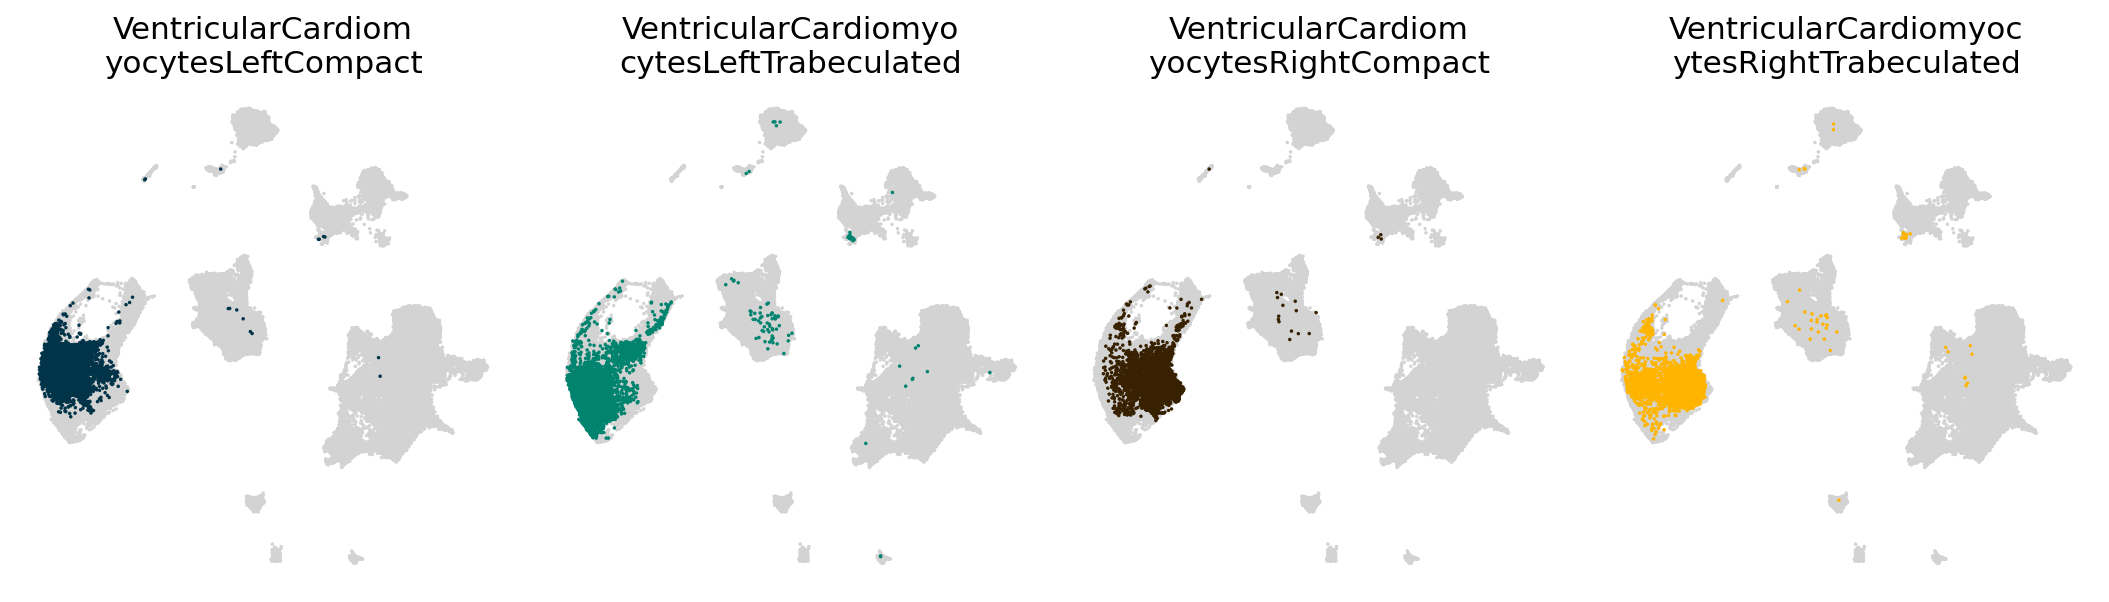

In [16]:
group_col = 'fine_grain_merged'
groups_to_plot = ['VentricularCardiomyocytesLeftCompact','VentricularCardiomyocytesLeftTrabeculated',
             'VentricularCardiomyocytesRightCompact','VentricularCardiomyocytesRightTrabeculated']

ncols = 6
if len(groups_to_plot)%ncols==0:
    nrows = len(groups_to_plot)//ncols
else:
    nrows = len(groups_to_plot)//ncols+1

if len(groups_to_plot)<ncols:
    fig_width = len(groups_to_plot)%ncols
else:
    fig_width = ncols
    
fig,axs=plt.subplots(nrows=nrows,ncols=ncols,figsize=(fig_width*5,nrows*4))
# Flatten the axs array for easier iteration in case of multiple rows and columns
axs_flat = axs.flatten()

for i,grp in enumerate(groups_to_plot):
    # ad = adata.copy()
    # update colors
    # get color in adata
    # ind = list(ad.obs[group_col].cat.categories).index(celltype)
    # ad.uns[group_col][ind] = 'darkred'
    
    # title
    middle_ind = round(len(grp)/2)
    grp_title = f'{grp[:middle_ind]}\n{grp[middle_ind:]}'
    # plot
    sc.pl.embedding(adata, basis=basis,
                  color=group_col, groups=grp,
                  size=10,legend_loc=None,
                  frameon=False,title=grp_title,
                  show=False, ax=axs_flat[i],
                 )
# Turn off any remaining subplots
for j in range(len(groups_to_plot), len(axs_flat)):
    fig.delaxes(axs_flat[j])

# fig.suptitle('Main Title for the Figure')
fig.tight_layout()

In [17]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor.h5ad')

# Plotting

In [6]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor.h5ad')
print(adata.X.data[:5])
basis = 'umap_correcting-donor-region_n-layers-2'
adata

[1. 1. 2. 1. 2.]


AnnData object with n_obs × n_vars = 83477 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'euploid_or_t21', 'donor_type', 'region_finest', 'flushed', 'scrublet_leiden', 'cluster_scrublet_score', 'leiden_scVI_0.1', 'leiden

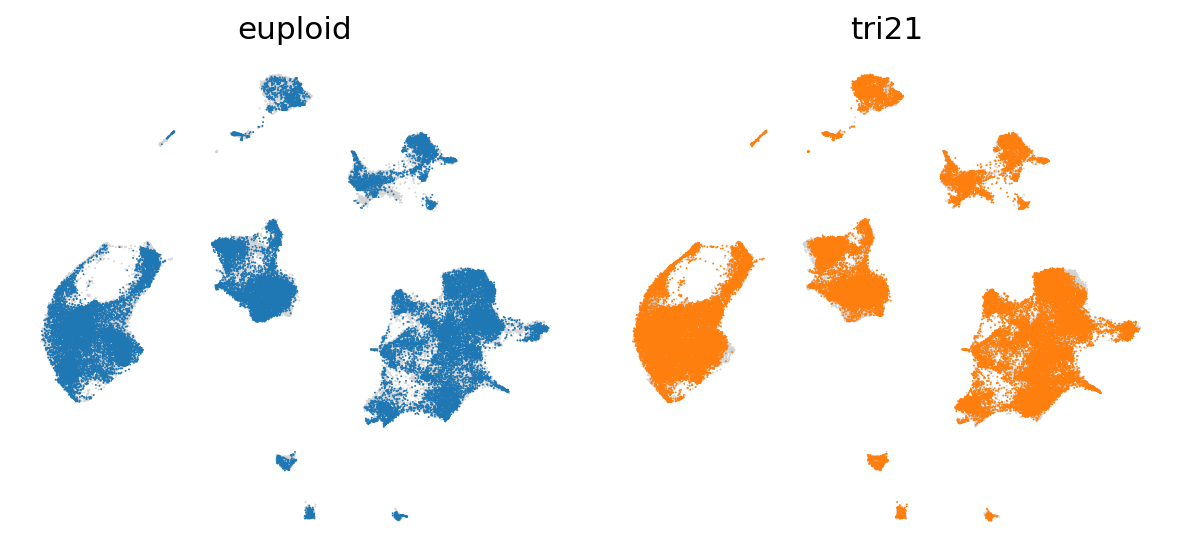

In [9]:
group_col = 'euploid_or_t21'
groups_to_plot = ['euploid',
 'tri21',
                 ]

plt.rcParams['axes.grid'] = False
fig,axs=plt.subplots(nrows=2,ncols=4,figsize=(15,7))
# Flatten the axs array for easier iteration in case of multiple rows and columns
axs_flat = axs.flatten()

for i,grp in enumerate(groups_to_plot):
    sc.pl.embedding(adata, basis=basis, color=[group_col], groups=grp, 
               size=3, frameon=False,
               show=False, ax=axs_flat[i], legend_loc=None, legend_fontsize=5,
               title=grp
              )
# Turn off any remaining subplots
for j in range(len(groups_to_plot), len(axs_flat)):
    fig.delaxes(axs_flat[j])

# fig.suptitle('Main Title for the Figure')
fig.tight_layout()
plt.savefig(f'{figdir}/Tri21_RNA_UMAP_eup-t21-separated.pdf', bbox_inches="tight",dpi=300)

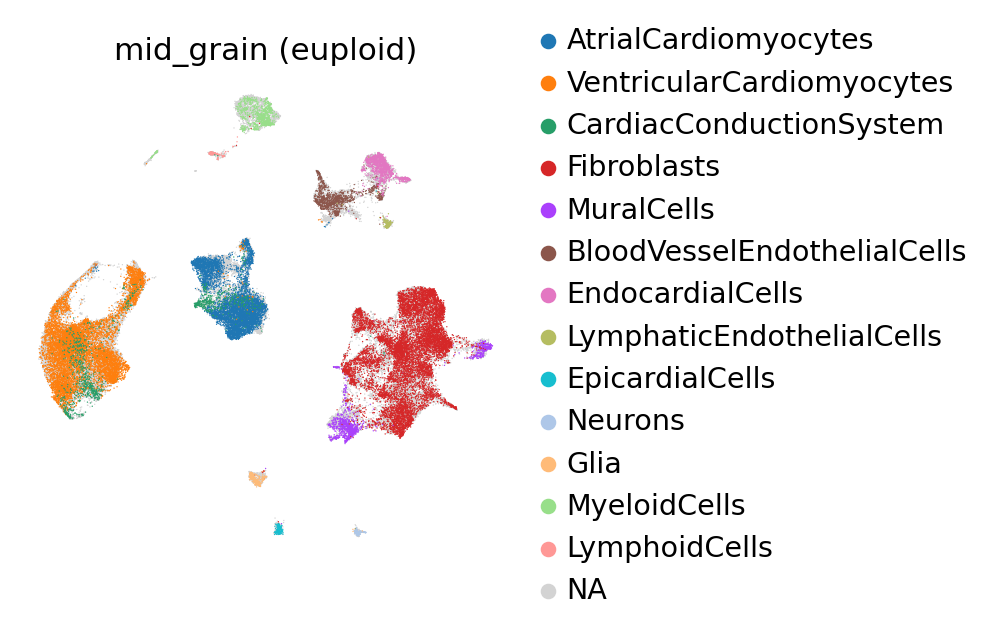

In [15]:
sc.pl.embedding(adata, basis=basis, color=['mid_grain'], frameon=False, show=False, title='mid_grain (euploid)')
plt.savefig(f'{figdir}/Tri21_RNA_UMAP_midgrain.pdf', bbox_inches="tight",dpi=300)

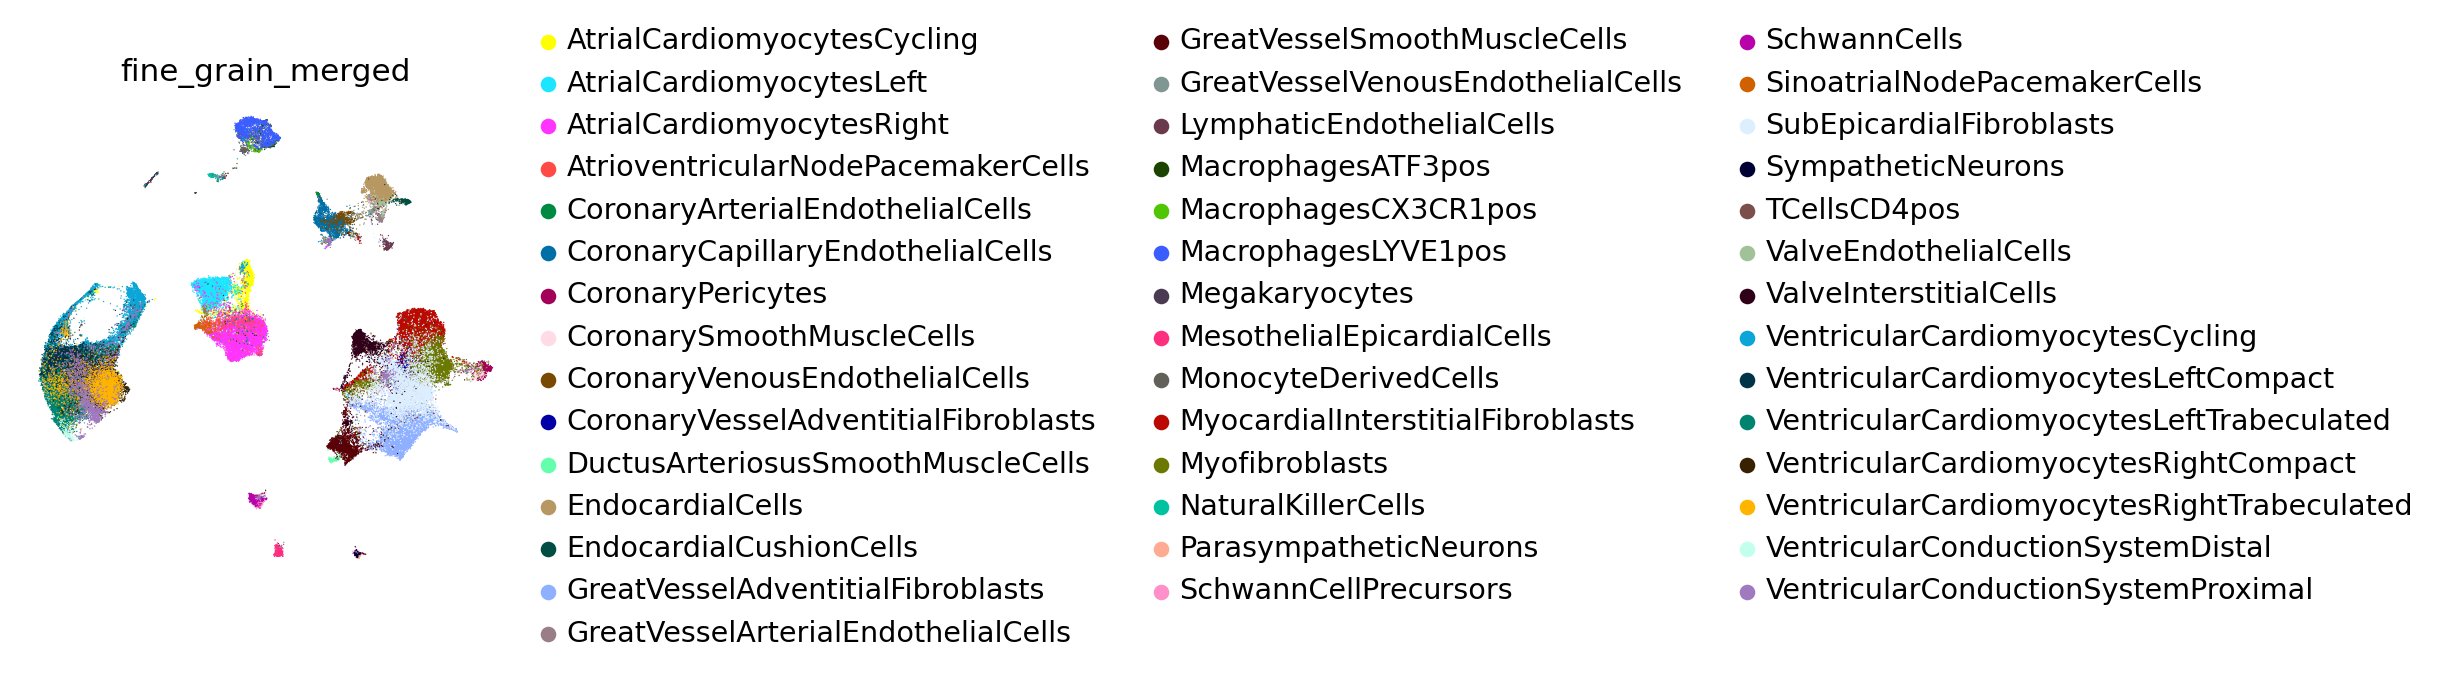

In [7]:
sc.pl.embedding(adata, basis=basis, color=['fine_grain_merged'], frameon=False, show=False)
plt.savefig(f'{figdir}/Tri21_RNA_UMAP_finegrain.pdf', bbox_inches="tight",dpi=300)

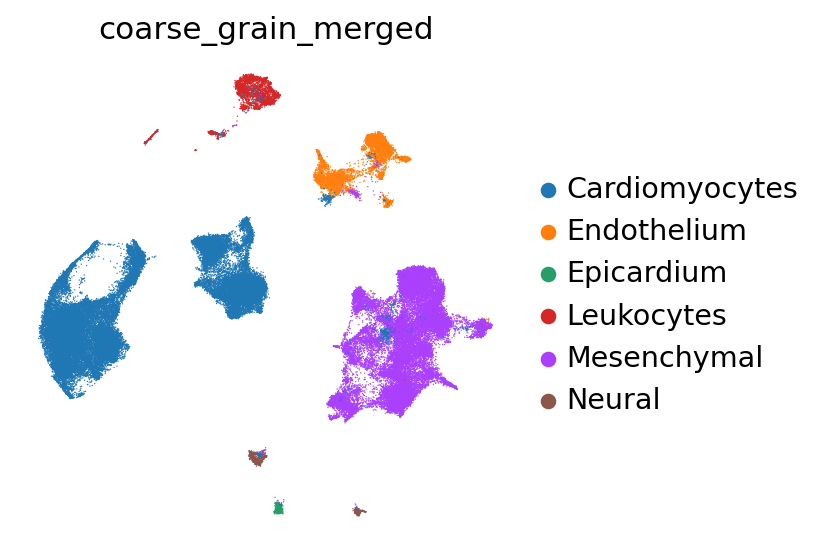

In [8]:
sc.pl.embedding(adata, basis=basis, color=['coarse_grain_merged'], frameon=False, show=False)
plt.savefig(f'{figdir}/Tri21_RNA_UMAP_coarsegrain.pdf', bbox_inches="tight",dpi=300)